# **Setup Environment**

In [ ]:
# =============================
# 📦 Install & Import Libraries
# =============================

import os                      # File and directory operations
import numpy as np             # Numerical operations (not used yet, but commonly used for EEG data)
import lzma                    # Compression library (used in NCD calculations)
import matplotlib.pyplot as plt  # For plotting graphs
from scipy.signal import butter, filtfilt  # For signal filtering (bandpass, etc.)
import pandas as pd            # DataFrame handling and CSV/Excel reading/writing
import zlib                    # Another compression library (used in NCD calculations)

# Install tqdm for progress bars in loops
!pip install tqdm

# ================================
# 🔗 Mount Google Drive to Colab
# ================================
from google.colab import drive

# Mounts your Google Drive to '/content/drive'
drive.mount('/content/drive')

print("✅ Environment setup complete!")

Mounted at /content/drive
✅ Environment setup complete!


**Here’s the full list of all paths**

In [ ]:
# ============================
# 📁 Define Project Directories
# ============================

# Root folder for the entire project inside Google Drive
main_path = "/content/drive/MyDrive/finalProject/"

# Folder containing raw EEG CSV files for ADHD participants (v1p to v61p)
adhd_folder = main_path + "adhdcsv/"

# Folder containing raw EEG CSV files for Control participants (v62p to v121p)
control_folder = main_path + "controlcsv/"

# Folder to save bandpass-filtered EEG files for ADHD participants
filtered_adhd_folder = main_path + "filteredadhdcsv/"

# Folder to save bandpass-filtered EEG files for Control participants
filtered_control_folder = main_path + "filteredcontrolcsv/"

# **preprocessing functions**

applying a bandpass filter (typically 1–40 Hz) to clean the EEG, remove noise.

After filtering, saved:

➔ ADHD participants' signals into /adhdcsv/

➔ Control participants' signals into /controlcsv/

In [ ]:
# ==============================
# 🎚️ Bandpass Filter Parameters
# ==============================

lowcut = 1.0     # Lower frequency bound (Hz)
highcut = 40.0   # Upper frequency bound (Hz)
fs = 128         # Sampling frequency (Hz)

# ================================================
# 🧠 Function: butter_bandpass
# Purpose : Design a Butterworth bandpass filter
# Inputs  : lowcut (Hz), highcut (Hz), fs (sampling rate), order (filter order)
# Output  : Filter coefficients (b, a)
# ================================================
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# ======================================================
# 🧠 Function: bandpass_filter
# Purpose : Apply a Butterworth bandpass filter to signal
# Inputs  : data (1D NumPy array or Pandas Series),
#           lowcut, highcut (Hz), fs (sampling rate), order
# Output  : Filtered signal (same shape as input)
# ======================================================
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)  # Apply forward-backward filter for zero-phase distortion
    return y

In [ ]:
# ========================================================================
# 🧠 Function: process_files
# Purpose : Apply bandpass filter to EEG CSV files and save new files
# Inputs  :
#    - input_folder: Path to original EEG CSV files
#    - output_folder: Path where filtered CSVs will be saved
#    - start_idx: First participant index (e.g., 1)
#    - end_idx: Last participant index (e.g., 61)
# Output  : Saves filtered CSV files to output_folder
# ========================================================================
def process_files(input_folder, output_folder, start_idx, end_idx):
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

    for i in range(start_idx, end_idx + 1):
        filename = f"v{i}p.csv"
        input_path = os.path.join(input_folder, filename)

        if os.path.exists(input_path):
            # Load the EEG data
            df = pd.read_csv(input_path)

            # Apply bandpass filter to each EEG channel (column)
            filtered_df = df.copy()
            for col in filtered_df.columns:
                filtered_df[col] = bandpass_filter(filtered_df[col], lowcut, highcut, fs)

            # Save the filtered data
            output_path = os.path.join(output_folder, f"filtered_v{i}p.csv")
            filtered_df.to_csv(output_path, index=False)

            print(f"✅ Filtered {filename} and saved to {output_path}")
        else:
            print(f"⚠️ File {filename} not found, skipping...")

In [ ]:
# ===================================================
# ▶️ Apply Filtering Function to ADHD & Control Data
# ===================================================

# Process ADHD participants: v1p.csv to v61p.csv
process_files(adhd_folder, filtered_adhd_folder, start_idx=1, end_idx=61)

# Process Control participants: v62p.csv to v121p.csv
process_files(control_folder, filtered_control_folder, start_idx=62, end_idx=121)

**Extracting Dominant EEG Band Sequences from Filtered Signals Using a Sliding Window Approach**

In [ ]:
# ========================================
# 🧠 Brainwave Region to Letter Mapping
# ========================================
region_to_letter = {
    "Delta": "D",
    "Theta": "T",
    "Alpha": "A",
    "Beta": "B",
    "Gamma": "G",
    "Unknown": "U"
}

# =========================================================
# 📥 Function: read_filtered_channel
# Purpose : Read a specific EEG channel (column) from a CSV
# Input   : filepath (CSV file path), channel (0-18)
# Output  : 1D NumPy array of signal values from the channel
# =========================================================
def read_filtered_channel(filepath, channel):
    df = pd.read_csv(filepath)
    return df[str(channel)].values

# =================================================================
# 📏 Function: split_signal_into_windows
# Purpose : Split a signal into fixed-length time windows
# Input   : signal (1D array), fs (sampling rate), window_sec (sec)
# Output  : List of NumPy arrays (each representing a window)
# =================================================================
def split_signal_into_windows(signal, fs=128, window_sec=1):
    window_size = fs * window_sec
    num_windows = len(signal) // window_size
    windows = np.array_split(signal[:num_windows * window_size], num_windows)
    return windows

# ======================================================================
# 📊 Function: compute_band_powers
# Purpose : Calculate frequency band power using FFT on a time window
# Input   : window (1D array), fs (sampling rate)
# Output  : Dictionary with power values for Delta, Theta, Alpha, Beta, Gamma
# ======================================================================
def compute_band_powers(window, fs=128):
    fft_result = np.fft.fft(window)
    freqs = np.fft.fftfreq(len(window), 1/fs)
    positive_freqs = freqs[:len(freqs)//2]
    magnitude = np.abs(fft_result[:len(fft_result)//2]) ** 2

    bands = {
        "Delta": (0.5, 4),
        "Theta": (4, 8),
        "Alpha": (8, 13),
        "Beta": (13, 30),
        "Gamma": (30, 40)
    }

    band_powers = {}
    for band_name, (low, high) in bands.items():
        idx_band = np.where((positive_freqs >= low) & (positive_freqs < high))
        band_power = np.sum(magnitude[idx_band])
        band_powers[band_name] = band_power

    return band_powers

# =================================================================================
# 🧠 Function: dominant_band_sequence
# Purpose : Generate a sequence of dominant frequency bands (labels) over time
# Input   : signal (1D EEG array), fs (sampling rate)
# Output  : List of dominant bands (e.g., ["Alpha", "Beta", ...]) per window
# =================================================================================
def dominant_band_sequence(signal, fs=128):
    window_size = fs * 2  # 2 seconds window (256 samples)
    sequence = []
    num_samples = len(signal)

    for start_idx in range(0, num_samples - window_size + 1):
        window = signal[start_idx:start_idx + window_size]
        band_powers = compute_band_powers(window, fs=fs)
        dominant_band = max(band_powers, key=band_powers.get)
        sequence.append(dominant_band)

    return sequence

# =========================================================================================
# 📁 Function: process_all_participants
# Purpose : Process all participants’ EEG data across all 19 channels, compute dominant
#           brainwave sequences, and save them as text files (letters D/T/A/B/G)
# Input   : output_folder (destination to save labeled sequences)
# Output  : Saves one .txt file per participant per channel with dominant band sequence
# =========================================================================================
def process_all_participants(output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for i in range(1, 122):  # Participant IDs: v1p to v121p
        if i <= 61:
            input_path = os.path.join(filtered_adhd_folder, f"filtered_v{i}p.csv")
        else:
            input_path = os.path.join(filtered_control_folder, f"filtered_v{i}p.csv")

        if not os.path.exists(input_path):
            print(f"⚠️ Missing {input_path}, skipping.")
            continue

        try:
            for channel in range(19):  # EEG channels 0 to 18
                signal = read_filtered_channel(input_path, channel)
                sequence = dominant_band_sequence(signal, fs=128)

                # Convert band names to letters (e.g., A, B, D...)
                sequence_text = ''.join(region_to_letter[region] for region in sequence)

                # Save to file
                output_filename = f"v{i}p_channel{channel}.txt"
                output_path = os.path.join(output_folder, output_filename)

                with open(output_path, 'w') as f:
                    f.write(sequence_text)

            print(f"✅ Processed and saved Participant v{i}p to {output_folder}")

        except Exception as e:
            print(f"❌ Error processing v{i}p: {e}")

In [ ]:
# Run dominant band processing with different window segment sizes (final output folders)
output_path = "/content/drive/MyDrive/finalProject/brainwave_sequences_10s/"
process_all_participants(output_path)

In [ ]:
output_path = "/content/drive/MyDrive/finalProject/brainwave_sequences_8s/"
process_all_participants(output_path)

In [ ]:
output_path = "/content/drive/MyDrive/finalProject/brainwave_sequences_6s/"
process_all_participants(output_path)

In [ ]:
output_path = "/content/drive/MyDrive/finalProject/brainwave_sequences_5s/"
process_all_participants(output_path)

In [ ]:
output_path = "/content/drive/MyDrive/finalProject/brainwave_sequences_2s/"
process_all_participants(output_path)

# **NCD Funtcion**

**ncd funtion with sliding window**

In [ ]:
import numpy as np
import bz2

# =========================================================================
# 🧪 Function: compress_size
# Purpose : Compress a string using bz2 and return the number of bytes
# Input   : data (string)
# Output  : Compressed length in bytes (int)
# =========================================================================
def compress_size(data):
    compressed = bz2.compress(data.encode('utf-8'))
    return len(compressed)

# ============================================================================================
# 🔁 Function: safe_compute_ncd_sliding_letters
# Purpose : Compute the **average NCD** between two sequences using a **sliding window**
# Input   : seq1, seq2 (strings of letters, e.g., "ABDTG")
# Output  : Mean NCD value (float) using a sliding comparison of the shorter over the longer
# Notes   :
#   - Sequences are space-separated to improve compression effectiveness
#   - The shorter sequence slides over the longer one
#   - At each step, NCD is calculated and averaged at the end
# ============================================================================================
def safe_compute_ncd_sliding_letters(seq1, seq2):
    s1 = ' '.join(seq1.strip())
    s2 = ' '.join(seq2.strip())

    s1_list = s1.split()
    s2_list = s2.split()

    if len(s1_list) <= len(s2_list):
        short = s1_list
        long = s2_list
    else:
        short = s2_list
        long = s1_list

    len_short = len(short)
    len_long = len(long)
    total_steps = len_long - len_short + 1

    text_short = ' '.join(short)
    compressed_short_size = compress_size(text_short)

    ncd_values = []
    for start in range(total_steps):
        window = long[start:start + len_short]
        text_window = ' '.join(window)

        compressed_window_size = compress_size(text_window)
        compressed_both_size = compress_size(text_short + text_window)

        ncd = (compressed_both_size - min(compressed_short_size, compressed_window_size)) / max(compressed_short_size, compressed_window_size)
        ncd_values.append(ncd)

    return np.mean(ncd_values)

**ncd function without sliding window**

In [ ]:
# ===================================================================================
# 📏 Function: ncd
# Purpose : Compute **regular NCD** (no sliding) between two letter sequences
# Input   : seq1, seq2 (strings of letters, e.g., "ABDTG")
# Output  : Single NCD value (float)
# Notes   :
#   - Sequences are trimmed to the same length before compression
#   - Uses bz2 compression
# ===================================================================================
def ncd(seq1, seq2):
    spaced1 = ' '.join(seq1.strip())
    spaced2 = ' '.join(seq2.strip())

    # Trim both to equal length
    min_len = min(len(spaced1), len(spaced2))
    spaced1 = spaced1[:min_len]
    spaced2 = spaced2[:min_len]

    c1 = compress_size(spaced1)
    c2 = compress_size(spaced2)
    c12 = compress_size(spaced1 + spaced2)

    return (c12 - min(c1, c2)) / max(c1, c2)

**function to read the brain_sequence txt file**

In [ ]:
# =======================================================================
# 📂 Function: read_sequence
# Purpose : Read a brainwave sequence from a file (saved as a string of letters)
# Input   : filepath (path to .txt file containing the sequence)
# Output  : Sequence string (e.g., "ABDBTGGT...")
# =======================================================================
def read_sequence(filepath):
    with open(filepath, 'r') as f:
        return f.read().strip()

# **dividing to parts**

In [ ]:
from tqdm import tqdm

# ====================================================================================
# ✂️ Function: split_sequence
# Purpose : Divide a full brainwave sequence into smaller parts of equal length
# Input   :
#   - seq (str): full sequence string (e.g., "ABBTTGGDA...")
#   - part_length (int): length of each part (e.g., 100)
# Output  : List of substrings (each of length `part_length`)
# Notes   : Discards any remainder shorter than `part_length`
# ====================================================================================
def split_sequence(seq, part_length):
    return [seq[i:i+part_length] for i in range(0, len(seq), part_length) if len(seq[i:i+part_length]) == part_length]

# =========================================================================================
# 🔄 Function: compare_parts_and_save
# Purpose : Compare all parts of participant `p1` vs all parts of participant `p2` for a
#           specific channel using regular NCD. Save results in an Excel file.
# Input   :
#   - sequence_folder (str): Folder with input .txt files (brainwave sequences)
#   - output_folder (str): Folder to store result Excel files
#   - p1, p2 (int): Participant IDs to compare (v{p1}p vs v{p2}p)
#   - channel (int): Channel number (0–18)
#   - part_length (int): Length of each part in the sequence
# Output  : None (writes comparison results to Excel file)
# File Naming: Result is saved as: channel{X}/v{p1}p_vs_v{p2}p_channel{X}.xlsx
# Skip Logic: If file already exists, or sequence files are missing, the function skips
# =========================================================================================
def compare_parts_and_save(sequence_folder, output_folder, p1, p2, channel, part_length):
    file1 = os.path.join(sequence_folder, f"v{p1}p_channel{channel}.txt")
    file2 = os.path.join(sequence_folder, f"v{p2}p_channel{channel}.txt")

    # 📂 Create output directory and define result path
    channel_folder = os.path.join(output_folder, f"channel{channel}")
    os.makedirs(channel_folder, exist_ok=True)
    file_path = os.path.join(channel_folder, f"v{p1}p_vs_v{p2}p_channel{channel}.xlsx")

    # ✅ Skip if already computed
    if os.path.exists(file_path):
        return

    # 🚫 Skip if sequence files are missing
    if not os.path.exists(file1) or not os.path.exists(file2):
        return

    # 🔄 Read sequences
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        seq1 = f1.read().strip()
        seq2 = f2.read().strip()

    # 🧩 Split into parts
    parts1 = split_sequence(seq1, part_length)
    parts2 = split_sequence(seq2, part_length)

    # 📏 Compute NCD between every part of p1 vs every part of p2
    rows = []
    for i, part1 in enumerate(parts1, start=1):
        for j, part2 in enumerate(parts2, start=1):
            val = ncd(part1, part2)
            rows.append([i, part1, j, part2, val])

    # 📊 Save results to Excel
    df = pd.DataFrame(rows, columns=[
        f"Part #{p1}p", f"Sequence {p1}p",
        f"Part #{p2}p", f"Sequence {p2}p",
        "NCD Value"
    ])
    df.to_excel(file_path, index=False)

# =========================================================================================
# 📚 Function: process_unique_pairs_by_channel
# Purpose : For each channel, compare all unique participant pairs (v1p-v2p, v1p-v3p, ...,
#           v120p-v121p) and save NCD results using `compare_parts_and_save`
# Input   :
#   - sequence_folder (str): Folder where all sequences are stored (1 txt per participant/channel)
#   - output_base_folder (str): Where to save Excel files
#   - part_length (int): Length of parts to divide sequences into
# Output  : None (Excel files are written for each participant pair per channel)
# =========================================================================================
def process_unique_pairs_by_channel(sequence_folder, output_base_folder, part_length):
    os.makedirs(output_base_folder, exist_ok=True)

    for channel in range(19):  # EEG channels 0–18
        print(f"\n🔁 Channel {channel}...")
        for p1 in tqdm(range(1, 121), desc=f"Channel {channel}"):
            for p2 in range(p1 + 1, 122):  # Only unique pairs (p2 > p1)
                compare_parts_and_save(
                    sequence_folder=sequence_folder,
                    output_folder=output_base_folder,
                    p1=p1,
                    p2=p2,
                    channel=channel,
                    part_length=part_length
                )


In [ ]:
process_unique_pairs_by_channel(
    sequence_folder="/content/drive/MyDrive/finalProject/brainwave_sequences_5s/",
    output_base_folder="/content/drive/MyDrive/finalProject/parts_ncd_5s/",
    part_length=1000
)

In [ ]:
process_unique_pairs_by_channel(
    sequence_folder="/content/drive/MyDrive/finalProject/brainwave_sequences_6s/",
    output_base_folder="/content/drive/MyDrive/finalProject/parts_ncd_6s/",
    part_length=1000
)

In [ ]:
process_unique_pairs_by_channel(
    sequence_folder="/content/drive/MyDrive/finalProject/brainwave_sequences_8s/",
    output_base_folder="/content/drive/MyDrive/finalProject/parts_ncd_8s/",
    part_length=1000
)

In [ ]:
process_unique_pairs_by_channel(
    sequence_folder="/content/drive/MyDrive/finalProject/brainwave_sequences_10s/",
    output_base_folder="/content/drive/MyDrive/finalProject/parts_ncd_10s/",
    part_length=1000
)

In [ ]:
process_unique_pairs_by_channel(
    sequence_folder="/content/drive/MyDrive/finalProject/brainwave_sequences_2s/",
    output_base_folder="/content/drive/MyDrive/finalProject/parts_ncd_2s/",
    part_length=1000
)

# **Classifacation using the parts and average**

In [ ]:
import os
import pandas as pd
import re
from tqdm.notebook import tqdm  # tqdm.notebook is preferred for Google Colab

# =============================================================================
# 🧩 Function: extract_file_info
# Purpose : Extracts participant IDs and channel number from filenames like
#           "v5p_vs_v88p_channel2.xlsx"
# Input   : filename (str)
# Output  : tuple (participant1_id, participant2_id, channel_id) or None
# =============================================================================
def extract_file_info(filename):
    match = re.match(r'v(\d+)p_vs_v(\d+)p_channel(\d+)', filename)
    if match:
        return tuple(map(int, match.groups()))
    return None

# =============================================================================
# 👤 Function: get_other_participant
# Purpose : Given a file and current participant ID, return the "other" ID
# Input   : filename (str), current_id (int)
# Output  : int (ID of the other participant)
# =============================================================================
def get_other_participant(file, current_id):
    i, j, _ = extract_file_info(file)
    return j if i == current_id else i

# =============================================================================
# 🧠 Function: get_group
# Purpose : Classify participant as 'ADHD' (IDs 1–61) or 'CONTROL' (62–121)
# Input   : participant_id (int)
# Output  : str ("ADHD" or "CONTROL")
# =============================================================================
def get_group(participant_id):
    return "ADHD" if 1 <= participant_id <= 61 else "CONTROL"

# =====================================================================================
# 📊 Function: process_all_participants_all_channels_using_avg
# Purpose : For each participant and channel, read NCD part-comparison results,
#           compute average NCD values with others, and classify using top 61 and
#           bottom 60 neighbors based on group match.
#
# Classification Logic:
#   - Sort all 121 comparisons for a participant based on average NCD value.
#   - Top 61 are assumed to be "similar" to the participant (same group expected).
#   - Bottom 60 are assumed to be "different" (other group expected).
#   - Classification score = (# correct matches) / 121
#
# Input   :
#   - version (str): one of "2s", "5s", "6s", etc. (used in folder naming)
#   - base_path (str): root path to the project (default set for Colab)
# Output  : For each participant-channel pair, saves a .txt file with average NCDs
#           and classification score to: avg/{version}/channel{X}/participant_{ID}.txt
# =====================================================================================
def process_all_participants_all_channels_using_avg(version, base_path="/content/drive/MyDrive/finalProject/"):
    for channel in tqdm(range(19), desc="🔁 Channels"):
        input_folder = os.path.join(base_path, f"parts_ncd_{version}", f"channel{channel}")
        output_folder = os.path.join(base_path, f"avg/{version}", f"channel{channel}")
        os.makedirs(output_folder, exist_ok=True)

        if not os.path.exists(input_folder):
            print(f"⚠️ Skipping missing folder: {input_folder}")
            continue

        for participant_id in tqdm(range(1, 122), desc=f"Channel {channel}", leave=False):
            output_file = os.path.join(output_folder, f"participant_{participant_id}.txt")

            # ✅ Skip if already processed
            if os.path.exists(output_file):
                print(f"⏭️ Skipping participant {participant_id} in channel {channel} (already exists)")
                continue

            results = []

            # 📂 Go through all Excel files in the input folder
            for file in os.listdir(input_folder):
                if not file.endswith(".xlsx") or "channel" not in file:
                    continue

                info = extract_file_info(file)
                if info is None:
                    continue

                i, j, _ = info
                if participant_id not in (i, j):
                    continue  # Only include files where this participant is involved

                full_path = os.path.join(input_folder, file)
                try:
                    df = pd.read_excel(full_path)
                except Exception as e:
                    print(f"❌ Failed to read {file}: {e}")
                    continue

                if 'NCD Value' not in df.columns:
                    print(f"⚠️ Skipping {file}: no 'NCD Value' column")
                    continue

                # ➕ Average NCD over all part comparisons
                avg_ncd = df["NCD Value"].mean()
                results.append((file, avg_ncd))

            if not results:
                continue

            # 📊 Sort all comparisons by NCD (smallest = most similar)
            results.sort(key=lambda x: x[1])

            # 🧠 Classification: Compare top 61 and bottom 60 against true group
            true_group = get_group(participant_id)
            same_group_top = 0
            other_group_bottom = 0

            top_61 = results[:61]
            bottom_60 = results[61:]

            for file, _ in top_61:
                other_id = get_other_participant(file, participant_id)
                if get_group(other_id) == true_group:
                    same_group_top += 1

            for file, _ in bottom_60:
                other_id = get_other_participant(file, participant_id)
                if get_group(other_id) != true_group:
                    other_group_bottom += 1

            correct_predictions = same_group_top + other_group_bottom
            classification_score = correct_predictions / 121

            # 💾 Save results to output file
            with open(output_file, "w") as f:
                f.write(f"Participant {participant_id} - Channel {channel}\n")
                for file, avg in results:
                    f.write(f"{file}: {avg:.5f}\n")
                f.write(f"\nClassification Score: {classification_score:.5f} ({correct_predictions}/121)\n")


In [ ]:
process_all_participants_all_channels_using_avg(version="5s")

In [ ]:
process_all_participants_all_channels_using_avg(version="6s")

In [ ]:
process_all_participants_all_channels_using_avg(version="8s")

In [ ]:
process_all_participants_all_channels_using_avg(version="10s")

In [ ]:
process_all_participants_all_channels_using_avg(version="2s")

# **Classifacation using the parts and median**

In [ ]:
import os
import pandas as pd
import re
from tqdm.notebook import tqdm  # Use notebook version for progress bars in Colab

# =============================================================================
# 📄 extract_file_info
# Extracts participant IDs and channel ID from filenames like:
#   "v5p_vs_v88p_channel2.xlsx"
# Returns: (participant1_id, participant2_id, channel_id) or None
# =============================================================================
def extract_file_info(filename):
    match = re.match(r'v(\d+)p_vs_v(\d+)p_channel(\d+)', filename)
    if match:
        return tuple(map(int, match.groups()))
    return None

# =============================================================================
# 🔁 get_other_participant
# Given a filename and one participant ID, return the "other" participant ID
# =============================================================================
def get_other_participant(file, current_id):
    i, j, _ = extract_file_info(file)
    return j if i == current_id else i

# =============================================================================
# 🧠 get_group
# Maps participant ID to group:
#   - "ADHD" if ID is from 1 to 61
#   - "CONTROL" if ID is from 62 to 121
# =============================================================================
def get_group(participant_id):
    return "ADHD" if 1 <= participant_id <= 61 else "CONTROL"

# =============================================================================
# 🧪 process_all_participants_all_channels_using_median
# Description:
#   For each participant and channel:
#     - Reads all NCD-part comparison Excel files involving that participant.
#     - Computes the median NCD value for each file.
#     - Sorts the files based on these median values (lower = more similar).
#     - The top 61 are expected to be the same group, the bottom 60 different.
#     - Classification score = correct matches / 121
# Output:
#   A text file per participant/channel containing the results and classification.
# Output path: /median/{version}/channel{X}/participant_{id}.txt
# =============================================================================
def process_all_participants_all_channels_using_median(version, base_path="/content/drive/MyDrive/finalProject/"):
    for channel in tqdm(range(19), desc="🔁 Channels"):
        input_folder = os.path.join(base_path, f"parts_ncd_{version}", f"channel{channel}")
        output_folder = os.path.join(base_path, f"median/{version}", f"channel{channel}")  # 📁 Output goes to /median
        os.makedirs(output_folder, exist_ok=True)

        if not os.path.exists(input_folder):
            print(f"⚠️ Skipping missing folder: {input_folder}")
            continue

        for participant_id in tqdm(range(1, 122), desc=f"Channel {channel}", leave=False):
            output_file = os.path.join(output_folder, f"participant_{participant_id}.txt")

            # ✅ Skip already processed participants
            if os.path.exists(output_file):
                print(f"⏭️ Skipping participant {participant_id} in channel {channel} (already exists)")
                continue

            results = []

            # 📂 Loop through all files in the folder
            for file in os.listdir(input_folder):
                if not file.endswith(".xlsx") or "channel" not in file:
                    continue

                info = extract_file_info(file)
                if info is None:
                    continue

                i, j, _ = info
                if participant_id not in (i, j):
                    continue  # Only use comparisons involving this participant

                full_path = os.path.join(input_folder, file)
                try:
                    df = pd.read_excel(full_path)
                except Exception as e:
                    print(f"❌ Failed to read {file}: {e}")
                    continue

                if 'NCD Value' not in df.columns:
                    print(f"⚠️ Skipping {file}: no 'NCD Value' column")
                    continue

                # 🔢 Compute the median of the NCD values
                median_ncd = df["NCD Value"].median()
                results.append((file, median_ncd))

            if not results:
                continue

            # 🔽 Sort results: smallest median NCDs first
            results.sort(key=lambda x: x[1])

            # 🧠 Classification
            true_group = get_group(participant_id)
            same_group_top = 0
            other_group_bottom = 0

            # 🎯 Check top 61 (should match group), bottom 60 (should not)
            top_61 = results[:61]
            bottom_60 = results[61:]

            for file, _ in top_61:
                other_id = get_other_participant(file, participant_id)
                if get_group(other_id) == true_group:
                    same_group_top += 1

            for file, _ in bottom_60:
                other_id = get_other_participant(file, participant_id)
                if get_group(other_id) != true_group:
                    other_group_bottom += 1

            correct_predictions = same_group_top + other_group_bottom
            classification_score = correct_predictions / 121

            # 💾 Save to output file
            with open(output_file, "w") as f:
                f.write(f"Participant {participant_id} - Channel {channel} (Median-Based)\n")
                for file, med in results:
                    f.write(f"{file}: {med:.5f}\n")
                f.write(f"\nClassification Score: {classification_score:.5f} ({correct_predictions}/121)\n")


In [ ]:
process_all_participants_all_channels_using_median("2s")

In [ ]:
process_all_participants_all_channels_using_median("5s")

In [ ]:
process_all_participants_all_channels_using_median("6s")

In [ ]:
process_all_participants_all_channels_using_median("8s")

In [ ]:
process_all_participants_all_channels_using_median("10s")

# **Classifacation using the parts and min**

In [ ]:
import os
import pandas as pd
import re
from tqdm.notebook import tqdm  # For progress bars in Colab notebooks

# =============================================================================
# 📄 extract_file_info
# Extracts participant IDs and channel number from filenames like:
#   "v5p_vs_v88p_channel2.xlsx"
# Returns: (participant1_id, participant2_id, channel_id)
# =============================================================================
def extract_file_info(filename):
    match = re.match(r'v(\d+)p_vs_v(\d+)p_channel(\d+)', filename)
    if match:
        return tuple(map(int, match.groups()))
    return None

# =============================================================================
# 🔁 get_other_participant
# Given a filename and one participant ID, returns the other participant in that comparison
# =============================================================================
def get_other_participant(file, current_id):
    i, j, _ = extract_file_info(file)
    return j if i == current_id else i

# =============================================================================
# 🧠 get_group
# Classifies participant into group:
#   - "ADHD" for IDs 1 to 61
#   - "CONTROL" for IDs 62 to 121
# =============================================================================
def get_group(participant_id):
    return "ADHD" if 1 <= participant_id <= 61 else "CONTROL"

# =============================================================================
# 🧪 process_all_participants_all_channels_using_min
# Description:
#   For each participant and each EEG channel:
#     - Read all NCD-part-comparison files where that participant appears.
#     - Extract the **minimum NCD value** from each file.
#     - Sort all files by minimum NCD (most similar = lowest NCD).
#     - Evaluate classification accuracy based on expected group similarity.
# Output:
#   Saves a text file per participant per channel to:
#     /min/{version}/channel{X}/participant_{ID}.txt
#   This file includes sorted file results and a classification score.
# =============================================================================
def process_all_participants_all_channels_using_min(version, base_path="/content/drive/MyDrive/finalProject/"):
    for channel in tqdm(range(19), desc="🔁 Channels"):
        input_folder = os.path.join(base_path, f"parts_ncd_{version}", f"channel{channel}")
        output_folder = os.path.join(base_path, f"min/{version}", f"channel{channel}")  # 📁 Save to /min folder
        os.makedirs(output_folder, exist_ok=True)

        if not os.path.exists(input_folder):
            print(f"⚠️ Skipping missing folder: {input_folder}")
            continue

        for participant_id in tqdm(range(1, 122), desc=f"Channel {channel}", leave=False):
            output_file = os.path.join(output_folder, f"participant_{participant_id}.txt")

            # ✅ Skip already processed results
            if os.path.exists(output_file):
                print(f"⏭️ Skipping participant {participant_id} in channel {channel} (already exists)")
                continue

            results = []

            # 🔍 Loop over all pairwise comparison files
            for file in os.listdir(input_folder):
                if not file.endswith(".xlsx") or "channel" not in file:
                    continue

                info = extract_file_info(file)
                if info is None:
                    continue

                i, j, _ = info
                if participant_id not in (i, j):
                    continue  # Only process files involving this participant

                full_path = os.path.join(input_folder, file)
                try:
                    df = pd.read_excel(full_path)
                except Exception as e:
                    print(f"❌ Failed to read {file}: {e}")
                    continue

                if 'NCD Value' not in df.columns:
                    print(f"⚠️ Skipping {file}: no 'NCD Value' column")
                    continue

                # 🔢 Extract the minimum NCD from the file
                min_ncd = df["NCD Value"].min()
                results.append((file, min_ncd))

            if not results:
                continue

            # 🔽 Sort comparisons by lowest NCD (most similar)
            results.sort(key=lambda x: x[1])

            # 🎯 Evaluate classification accuracy
            true_group = get_group(participant_id)
            same_group_top = 0
            other_group_bottom = 0

            # Top 61 files expected to be same group, bottom 60 expected to be other group
            top_61 = results[:61]
            bottom_60 = results[61:]

            for file, _ in top_61:
                other_id = get_other_participant(file, participant_id)
                if get_group(other_id) == true_group:
                    same_group_top += 1

            for file, _ in bottom_60:
                other_id = get_other_participant(file, participant_id)
                if get_group(other_id) != true_group:
                    other_group_bottom += 1

            correct_predictions = same_group_top + other_group_bottom
            classification_score = correct_predictions / 121

            # 💾 Write results to text file
            with open(output_file, "w") as f:
                f.write(f"Participant {participant_id} - Channel {channel} (Min-Based)\n")
                for file, min_val in results:
                    f.write(f"{file}: {min_val:.5f}\n")
                f.write(f"\nClassification Score: {classification_score:.5f} ({correct_predictions}/121)\n")


In [ ]:
process_all_participants_all_channels_using_min("2s")

In [ ]:
process_all_participants_all_channels_using_min("5s")

In [ ]:
process_all_participants_all_channels_using_min("6s")

In [ ]:
process_all_participants_all_channels_using_min("8s")

In [ ]:
process_all_participants_all_channels_using_min("10s")

# **Classification based on median for (avg,median,min)**

In [ ]:
import os
import pandas as pd
import re
from tqdm.notebook import tqdm  # For progress bars in Google Colab

# =============================================================================
# 📄 extract_file_info
# Extracts participant IDs and channel number from filenames like:
#   "v12p_vs_v89p_channel3.xlsx"
# Returns: (participant1_id, participant2_id, channel_id)
# =============================================================================
def extract_file_info(filename):
    match = re.match(r'v(\d+)p_vs_v(\d+)p_channel(\d+)', filename)
    if match:
        return tuple(map(int, match.groups()))
    return None

# =============================================================================
# 🧠 get_group
# Maps participant ID to its group:
#   - "ADHD" if ID is from 1 to 61
#   - "CONTROL" if ID is from 62 to 121
# =============================================================================
def get_group(participant_id):
    return "ADHD" if 1 <= participant_id <= 61 else "CONTROL"

# =============================================================================
# 📊 classification_accuracy_based_on_median
# Description:
#   - For a specific signal window version (e.g., "10s", "5s", etc.),
#     this function evaluates **classification accuracy** for each participant
#     across 3 methods: "avg", "median", "min"
#   - For each method/channel/participant:
#       • Loads the NCD scores with all other participants (120 values)
#       • Calculates the median NCD value
#       • Predicts other participant's group:
#           if val <= median ⇒ same group as current participant
#           if val >  median ⇒ opposite group
#       • Compares with true group and computes accuracy
#
# Inputs:
#   - version: subfolder name of signal window (e.g., "10s", "5s", etc.)
#   - base_path: main folder path (default is finalProject folder)
#
# Output:
#   - Creates Excel file per participant under:
#     /classification_based_on_median/{version}/participant_{ID}.xlsx
#   - Each Excel file includes accuracy per channel per method
# =============================================================================
def classification_accuracy_based_on_median(version, base_path="/content/drive/MyDrive/finalProject"):
    versions = ["avg", "median", "min"]
    channels = list(range(19))         # 0 to 18
    participants = list(range(1, 122)) # v1p to v121p
    output_base = os.path.join(base_path, "classification_based_on_median", version)
    os.makedirs(output_base, exist_ok=True)

    for participant_id in tqdm(participants, desc=f"🔁 Version {version}"):
        summary_data = []  # One row per method (avg, median, min)

        for vtype in versions:
            row = []
            for channel in channels:
                input_file = os.path.join(base_path, vtype, version, f"channel{channel}", f"participant_{participant_id}.txt")
                if not os.path.exists(input_file):
                    row.append("NA")
                    continue

                try:
                    with open(input_file, "r") as f:
                        lines = f.readlines()
                except:
                    row.append("NA")
                    continue

                ncd_values = []
                compared_ids = []

                # 🧾 Extract NCD values and corresponding other participant IDs
                for line in lines:
                    if line.startswith("v") and ":" in line:
                        try:
                            fname, val = line.split(":")
                            val = float(val.strip())
                            ids = extract_file_info(fname.strip())
                            if ids:
                                i, j, _ = ids
                                other_id = j if i == participant_id else i
                                ncd_values.append(val)
                                compared_ids.append(other_id)
                        except:
                            continue

                # Skip if not all 120 values are present
                if len(ncd_values) != 120:
                    row.append("NA")
                    continue

                # 💡 Classification logic based on median threshold
                median_val = pd.Series(ncd_values).median()
                participant_group = get_group(participant_id)

                correct_predictions = 0
                for val, other_id in zip(ncd_values, compared_ids):
                    predicted_group = participant_group if val <= median_val else ("CONTROL" if participant_group == "ADHD" else "ADHD")
                    true_group = get_group(other_id)
                    if predicted_group == true_group:
                        correct_predictions += 1

                accuracy = correct_predictions / 120
                row.append(round(accuracy, 5))  # Round for readability

            summary_data.append(row)

        # 📝 Save results to Excel
        df = pd.DataFrame(summary_data, columns=[f"Channel {i}" for i in channels], index=["avg", "median", "min"])
        output_file = os.path.join(output_base, f"participant_{participant_id}.xlsx")
        df.to_excel(output_file)

    print(f"✅ Done: All classification accuracy files saved as .xlsx under {output_base}")


In [ ]:
classification_accuracy_based_on_median("5s")

In [ ]:
classification_accuracy_based_on_median("6s")

In [ ]:
classification_accuracy_based_on_median("8s")

In [ ]:
classification_accuracy_based_on_median("10s")

In [ ]:
classification_accuracy_based_on_median("2s")

In [ ]:
import os
import pandas as pd

# =============================================================================
# 🧠 find_max_classification_score
# Description:
#   - Iterates over all versions (time windows) of classification results
#   - For each participant Excel file (contains accuracy across 19 channels and 3 methods),
#     it identifies the highest classification score
#
# Inputs:
#   - base_path: base folder where classification results are stored
#     Default path: "/content/drive/MyDrive/finalProject/classification_based_on_median"
#
# Output:
#   - For each version ("2s", "5s", "6s", "8s", "10s"):
#     ➤ Prints the highest classification score found
#     ➤ Shows the participant ID, channel, and method responsible for that score
# =============================================================================
def find_max_classification_score(base_path="/content/drive/MyDrive/finalProject/classification_based_on_median"):
    versions = ["5s", "6s", "8s", "10s", "2s"]  # All processed time-window versions
    methods = ["avg", "median", "min"]         # NCD aggregation methods
    channels = [f"Channel {i}" for i in range(19)]  # Channel column headers

    for version in versions:
        print(f"\n🔎 Searching in version: {version}")
        folder_path = os.path.join(base_path, version)

        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        max_score = -1         # Highest accuracy found so far
        best_info = {}         # Metadata for the highest score

        for filename in os.listdir(folder_path):
            if not filename.endswith(".xlsx"):
                continue

            filepath = os.path.join(folder_path, filename)
            participant_id = filename.replace("participant_", "").replace(".xlsx", "")

            try:
                df = pd.read_excel(filepath, index_col=0)  # Each file has methods as index, channels as columns
            except Exception as e:
                print(f"❌ Failed to read {filepath}: {e}")
                continue

            for method in methods:
                if method not in df.index:
                    continue  # Skip if method row missing

                for channel in channels:
                    value = df.at[method, channel]
                    if isinstance(value, (int, float)) and value > max_score:
                        # 🔼 New max found!
                        max_score = value
                        best_info = {
                            "version": version,
                            "participant": participant_id,
                            "channel": channel,
                            "method": method,
                            "score": value
                        }

        # 🟢 Final best for current version
        if best_info:
            print(f"✅ Max classification score in version {version}:")
            print(f"   Participant: {best_info['participant']}")
            print(f"   Channel: {best_info['channel']}")
            print(f"   Method: {best_info['method']}")
            print(f"   Score: {best_info['score']:.5f}")
        else:
            print("⚠️ No valid classification scores found.")


In [ ]:
find_max_classification_score()

In [ ]:
import os
import pandas as pd

# =============================================================================
# 📊 generate_high_classification_summary
# -----------------------------------------------------------------------------
# Purpose:
#   - Scans classification results (stored as Excel files for each participant)
#   - Identifies and extracts all classification scores ≥ 0.60
#   - Compiles them into a single summary table with metadata
#
# Inputs:
#   - base_path: Root folder of the project
#     (defaults to "/content/drive/MyDrive/finalProject")
#
# Outputs:
#   - Creates a summary Excel file with all high classification scores:
#     ➤ version (e.g., 2s, 5s, ...)
#     ➤ score (≥ 0.60)
#     ➤ participant ID
#     ➤ channel number (0–18)
#     ➤ method used (avg, median, min)
#
#   - Output is saved to: /high_scores_summary/high_scores.xlsx
# =============================================================================
def generate_high_classification_summary(base_path="/content/drive/MyDrive/finalProject"):
    versions = ["2s", "5s", "6s", "8s", "10s"]         # EEG window sizes
    methods = ["avg", "median", "min"]                # Score aggregation methods
    summary_rows = []                                 # List to collect high-score entries

    for version in versions:
        print(f"🔎 Processing version: {version}")
        version_path = os.path.join(base_path, "classification_based_on_median", version)

        if not os.path.exists(version_path):
            print(f"⚠️ Skipping missing folder: {version_path}")
            continue

        # Loop through each participant file
        for file in os.listdir(version_path):
            if not file.endswith(".xlsx"):
                continue

            # Extract participant ID from filename
            participant_id = int(file.split("_")[1].split(".")[0])
            filepath = os.path.join(version_path, file)

            try:
                # Read the Excel file (index = method, columns = Channel 0–18)
                df = pd.read_excel(filepath, index_col=0)
            except Exception as e:
                print(f"❌ Failed to read {file}: {e}")
                continue

            # For each method (row)
            for method in methods:
                if method not in df.index:
                    continue

                # For each channel (column)
                for channel in df.columns:
                    try:
                        score = df.loc[method, channel]
                        # Keep only scores ≥ 0.60
                        if isinstance(score, (int, float)) and score >= 0.60:
                            summary_rows.append({
                                "score number": len(summary_rows) + 1,
                                "version": version,
                                "score": round(score, 5),
                                "participant": participant_id,
                                "channel": channel.replace("Channel ", ""),  # Just number
                                "method": method
                            })
                    except Exception:
                        continue  # Skip if any issue in reading this cell

    # Create and save summary DataFrame
    summary_df = pd.DataFrame(summary_rows)

    output_folder = os.path.join(base_path, "high_scores_summary")
    os.makedirs(output_folder, exist_ok=True)

    output_file = os.path.join(output_folder, "high_scores.xlsx")
    summary_df.to_excel(output_file, index=False)

    print(f"\n✅ Summary file saved to: {output_file}")


In [ ]:
generate_high_classification_summary()

# **Graphs**

📋 Columns: ['score number', 'version', 'score', 'participant', 'channel', 'method']


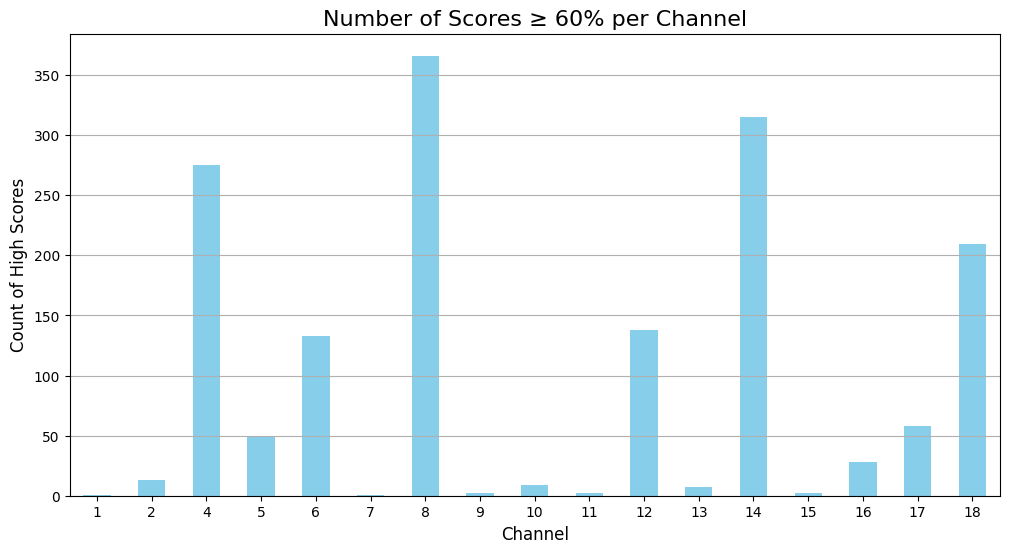

✅ Chart saved to: /content/drive/MyDrive/finalProject/high_scores_summary/channel_score_counts.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# 📊 High Classification Score Chart Generator
# ----------------------------------------------------------------------------
# Purpose:
#   - Load the summary of high classification scores from an Excel file
#   - Count how many scores (≥ 60%) appear for each EEG channel
#   - Plot a bar chart: Channel vs. Number of High Scores
#   - Save the chart as a PNG image
# ============================================================================

# === Step 1: Load Excel File ===
file_path = "/content/drive/MyDrive/finalProject/high_scores_summary/high_scores.xlsx"
df = pd.read_excel(file_path)

# === Step 2: Clean Column Names ===
df.columns = df.columns.str.strip()  # Ensure column names have no leading/trailing whitespace
print("📋 Columns:", df.columns.tolist())

# === Step 3: Filter and Count High Scores per Channel ===
# Check required columns exist
if "score" not in df.columns or "channel" not in df.columns:
    raise ValueError("Missing required columns 'score' or 'channel' in the file.")

# Filter scores ≥ 0.60 and count occurrences per channel
channel_counts = (
    df[df["score"] >= 0.60]["channel"]
    .value_counts()        # Count high scores per channel
    .sort_index()          # Sort channels numerically
)

# === Step 4: Plot the Bar Chart ===
plt.figure(figsize=(12, 6))
channel_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Scores ≥ 60% per Channel", fontsize=16)
plt.xlabel("Channel", fontsize=12)
plt.ylabel("Count of High Scores", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')

# === Step 5: Save the Chart as PNG ===
output_path = "/content/drive/MyDrive/finalProject/high_scores_summary/channel_score_counts.png"
plt.savefig(output_path, bbox_inches='tight')
plt.show()

print(f"✅ Chart saved to: {output_path}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ============================================================================
# 📊 Per-Version Channel Performance Chart Generator
# ----------------------------------------------------------------------------
# Purpose:
#   - For each sliding window version (e.g., 2s, 5s, ...), generate a chart
#     showing how many EEG channels achieved classification score ≥ 60%.
#   - Saves each chart as a separate PNG image.
# ============================================================================

# === Load data from summary Excel file ===
file_path = "/content/drive/MyDrive/finalProject/high_scores_summary/high_scores.xlsx"
df = pd.read_excel(file_path)

# === Clean column names (remove any leading/trailing spaces) ===
df.columns = df.columns.str.strip()

# === Check that required columns are present ===
required_cols = {"score", "channel", "version"}
if not required_cols.issubset(set(df.columns)):
    raise ValueError(f"Missing required columns: {required_cols - set(df.columns)}")

# === Define all window versions to process ===
versions = ["2s", "5s", "6s", "8s", "10s"]

# === Set output directory for saving charts ===
output_dir = "/content/drive/MyDrive/finalProject/high_scores_summary"

# === Generate bar chart for each version ===
for version in versions:
    # Filter for current version and scores >= 0.60
    version_df = df[(df["version"] == version) & (df["score"] >= 0.60)]

    if version_df.empty:
        print(f"⚠️ No high scores for version {version}, skipping.")
        continue

    # Count number of high scores per channel
    channel_counts = version_df["channel"].value_counts().sort_index()

    # === Plotting ===
    plt.figure(figsize=(12, 6))
    channel_counts.plot(kind="bar", color="skyblue")
    plt.title(f"Scores ≥ 60% per Channel — Version {version}", fontsize=16)
    plt.xlabel("Channel", fontsize=12)
    plt.ylabel("Count of High Scores", fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y')

    # === Save chart as PNG ===
    output_file = os.path.join(output_dir, f"channel_scores_{version}.png")
    plt.savefig(output_file, bbox_inches='tight')
    plt.close()

    print(f"✅ Saved: {output_file}")


✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/channel_scores_2s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/channel_scores_5s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/channel_scores_6s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/channel_scores_8s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/channel_scores_10s.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ============================================================================
# 📊 Participant High Score Visualizer
# ----------------------------------------------------------------------------
# Purpose:
#   - Generate bar charts showing how many channels for each participant
#     achieved a classification score ≥ 60%.
#   - Output includes:
#       1. One chart for ALL versions combined
#       2. One chart per version (2s, 5s, 6s, 8s, 10s)
# ============================================================================

# === Define file paths and version names ===
file_path = "/content/drive/MyDrive/finalProject/high_scores_summary/high_scores.xlsx"
output_dir = "/content/drive/MyDrive/finalProject/high_scores_summary"
versions = ["2s", "5s", "6s", "8s", "10s"]

# === Load the Excel summary file ===
df = pd.read_excel(file_path)

# === Clean column names (remove any extra spaces) ===
df.columns = df.columns.str.strip()

# ============================================================================
# 🧩 Function: Plot & Save Participant Score Histogram
# ----------------------------------------------------------------------------
# Parameters:
#   - df_subset: filtered DataFrame (can be full or per version)
#   - title: plot title
#   - filename: output image filename
# ============================================================================
def plot_scores_per_participant(df_subset, title, filename):
    # Count number of high scores per participant (score ≥ 0.60)
    participant_counts = df_subset[df_subset["score"] >= 0.60]["participant"] \
                         .value_counts().sort_index()

    # === Plot bar chart ===
    plt.figure(figsize=(16, 6))
    participant_counts.plot(kind="bar", color="mediumseagreen")
    plt.title(title, fontsize=16)
    plt.xlabel("Participant Number", fontsize=12)
    plt.ylabel("Count of High Scores (≥ 60%)", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()

    # === Save chart ===
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path)
    plt.close()
    print(f"✅ Saved: {save_path}")

# ============================================================================
# ✅ Generate Chart 1: All Versions Combined
# ============================================================================
plot_scores_per_participant(
    df,
    "High Classification Scores (≥ 60%) per Participant – All Versions",
    "participant_scores_all_versions.png"
)

# ============================================================================
# ✅ Generate Chart 2: Per Version (2s, 5s, 6s, 8s, 10s)
# ============================================================================
for version in versions:
    df_version = df[df["version"] == version]
    if df_version.empty:
        print(f"⚠️ No data for version {version}, skipping.")
        continue

    plot_scores_per_participant(
        df_version,
        f"High Classification Scores (≥ 60%) per Participant – Version {version}",
        f"participant_scores_{version}.png"
    )


✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_all_versions.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_2s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_5s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_6s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_8s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_10s.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ============================================================================
# 📈 Participant High Score Visualizer — Per Method & Version
# ----------------------------------------------------------------------------
# Purpose:
#   - For each NCD method ("avg", "median", "min"), this script:
#       1. Shows how many times each participant got ≥ 60% classification
#          scores across all versions combined
#       2. Creates separate graphs per version ("2s", "5s", "6s", "8s", "10s")
#   - Output: Bar charts saved as .png files under high_scores_summary
# ============================================================================

# === Define data paths and configuration ===
file_path = "/content/drive/MyDrive/finalProject/high_scores_summary/high_scores.xlsx"
output_dir = "/content/drive/MyDrive/finalProject/high_scores_summary"
versions = ["2s", "5s", "6s", "8s", "10s"]
methods = ["avg", "median", "min"]

# === Load the summary Excel file ===
df = pd.read_excel(file_path)

# Clean column names (strip whitespace)
df.columns = df.columns.str.strip()

# ============================================================================
# 🧩 Function: Plot and Save Participant Score Histogram
# ----------------------------------------------------------------------------
# Inputs:
#   - df_subset: Filtered DataFrame (per method/version)
#   - title: Title for the plot
#   - filename: Output PNG filename
# Output:
#   - Saves a bar chart showing number of high scores (≥ 60%) per participant
# ============================================================================
def plot_scores(df_subset, title, filename):
    # Count scores ≥ 0.60 per participant
    participant_counts = df_subset[df_subset["score"] >= 0.60]["participant"] \
                         .value_counts().sort_index()

    # Plot the bar chart
    plt.figure(figsize=(16, 6))
    participant_counts.plot(kind="bar", color="steelblue")
    plt.title(title, fontsize=16)
    plt.xlabel("Participant Number", fontsize=12)
    plt.ylabel("Count of High Scores (≥ 60%)", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()

    # Save the chart
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path)
    plt.close()
    print(f"✅ Saved: {save_path}")

# ============================================================================
# 📊 Main Loop: Generate Graphs for Each Method
# ============================================================================
for method in methods:
    # === Step 1: All Versions Combined ===
    df_method = df[df["method"] == method]
    plot_scores(
        df_method,
        f"High Scores ≥ 60% per Participant – Method: {method.upper()} (All Versions)",
        f"participant_scores_{method}_all_versions.png"
    )

    # === Step 2: Per Version ===
    for version in versions:
        df_subset = df_method[df_method["version"] == version]
        if df_subset.empty:
            print(f"⚠️ No data for method '{method}' in version '{version}', skipping.")
            continue

        plot_scores(
            df_subset,
            f"High Scores ≥ 60% per Participant – Method: {method.upper()} | Version: {version}",
            f"participant_scores_{method}_{version}.png"
        )


✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_avg_all_versions.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_avg_2s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_avg_5s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_avg_6s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_avg_8s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_avg_10s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_median_all_versions.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_median_2s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_median_5s.png
✅ Saved: /content/drive/MyDrive/finalProject/high_scores_summary/participant_scores_median_6s.png
✅ Saved: /content